#Dropouts - 0.25,0.50,0.75

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml("mnist_784",version=1)

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib as mpl
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os 
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR

Storing the MNSIT data into X and y

In [ ]:
import numpy as np
X,y=mnist["data"],mnist["target"]
y=y.astype(int)
X=((X/255.)-.5)*2
print(X.shape,y.shape)
print(min(y),max(y))
print(type(X),type(y))
print(np.min(X), np.max(X))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


Defining a class hyperparam to store the values of learning rate, number of epochs,mini-batch size and momentum.

In [ ]:
# Define key hyperparameters
class hyperparam:
    
    lr = 0.05  # learning rate
    num_epochs = 50  # Number of epochs
    bs = 50  # Mini-batch size 
    moment = 0.9 # Momentum SGD 

###Splitting into train and test data

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #train_images, val_images, train_labels, val_labels

Separate into labels and training images and reshape the images

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state = 42)

for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]
    
    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]

print(X_train_strat.shape,y_train_strat.shape,X_dev_strat.shape,y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [ ]:
train_images = X_train_strat.reshape(X_train_strat.shape[0], 28, 28) #reshape the images to 54000,28,28 from 54000,784
val_images = X_dev_strat.reshape(X_dev_strat.shape[0], 28, 28)
test_images = X_test.reshape(X_test.shape[0], 28, 28)

Converting images to tensors and normalising them

In [ ]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(y_train_strat)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(y_dev_strat)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

Load images into the data generator

In [ ]:
train_loader = DataLoader(train_tensor, batch_size=50, num_workers=6, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=50, num_workers=6, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=50, num_workers=6, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Define the CNN Model
####dropout-0.25

Dropout of 0.25 added to the CNN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25), #dropout of 0.25 added
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25), #dropout of 0.25 added
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

Glorat Initialisation 

In [ ]:
def init_weights(m): 
  if type(m) == nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

In [ ]:
conv_model = Net()
conv_model.apply(init_weights) #Initialising the weights using the glorat Initialisation method
conv_model 

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(i

###Defining the optimizer and loss functions

SGD Optimiser - 
params:- learning rate-0.05,momentum-0.9 
and using the Cross Entropy Loss Function

Learning Rate Schedular adjusting 10% every 10 epochs

torch.cuda to check if any gpu is available to use it. Google Collab GPU was used here to run the files.

In [ ]:
optimizer = torch.optim.SGD(params=conv_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.10) #learning rate scheduler
criterion = nn.CrossEntropyLoss() #cross entropy loss to calculate the loss between the predicted and the actual
if torch.cuda.is_available(): # To check if any gpu is available to run on
    print("GPU available")
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

GPU available


###Training the Model

In [ ]:
#Train the DNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    conv_model.train(True) 
    exp_lr_scheduler.step() #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            
            #Model computations
            out1 = conv_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      conv_model.eval()

      for local_batch,local_labels in val_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        #local_batch,local_labels=Variable(local_batch),Variable(local_labels)
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=conv_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(val_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("Accuracy for ",epoch," epoch -","train_accuracy-",tr_accuracy," Validation_accuracy- ",dev_accuracy)



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Accuracy for  0  epoch - train_accuracy- 0.9131296296296296  Validation_accuracy-  0.20016666666666666
Accuracy for  1  epoch - train_accuracy- 0.9515740740740741  Validation_accuracy-  0.09933333333333333
Accuracy for  2  epoch - train_accuracy- 0.9515185185185185  Validation_accuracy-  0.09933333333333333
Accuracy for  3  epoch - train_accuracy- 0.9677222222222223  Validation_accuracy-  0.11233333333333333
Accuracy for  4  epoch - train_accuracy- 0.973037037037037  Validation_accuracy-  0.09866666666666667
Accuracy for  5  epoch - train_accuracy- 0.9757592592592592  Validation_accuracy-  0.09866666666666667
Accuracy for  6  epoch - train_accuracy- 0.9775925925925926  Validation_accuracy-  0.11233333333333333
Accuracy for  7  epoch - train_accuracy- 0.9796296296296296  Validation_accuracy-  0.11233333333333333
Accuracy for  8  epoch - train_accuracy- 0.9779074074074074  Validation_accuracy-  0.09983333333333333
Accuracy for  9  epoch - train_accuracy- 0.9846666666666667  Validation_ac

###Plotting the Learning Curves - for the Test and the Validation Sets

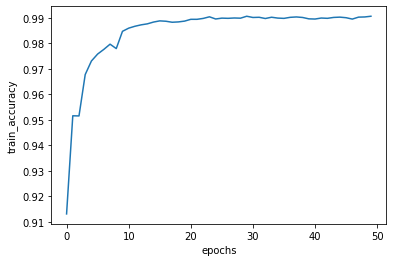

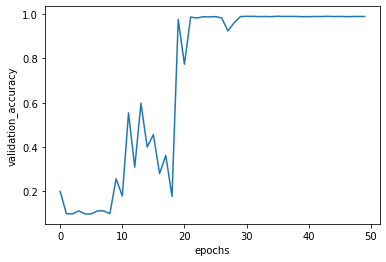

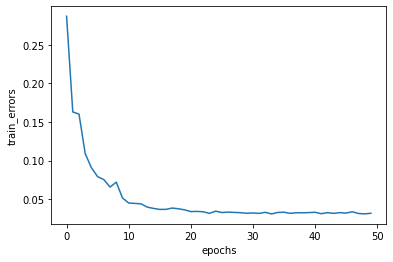

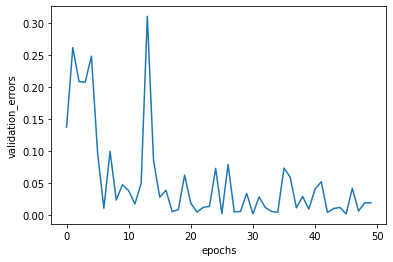

In [ ]:
plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

With a dropout of 0.25 there is not much difference to the baseline SGD model. The model converges after 20 epochs and the validation accuracy improves after that and it is pretty good.

###Test Set


In [ ]:
 def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicted Labels

In [ ]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


###Test Accuracy and the Confusion Matrix on the test Set


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
accuracy=accuracy_score(y_true,y_pred)
confusion_matrix=confusion_matrix(y_true, y_pred)
print("Test Accuracy - ",accuracy*100,"%")
print(" \nConfusion Matrix- ")
print(confusion_matrix)

Test Accuracy -  99.14 %
 
Confusion Matrix- 
[[ 974    1    1    0    0    0    3    1    0    0]
 [   0 1132    0    1    0    1    1    0    0    0]
 [   1    0 1023    0    0    0    0    6    2    0]
 [   0    0    1 1006    0    1    0    0    2    0]
 [   0    0    1    0  972    0    4    1    1    3]
 [   0    0    0    5    0  883    2    1    1    0]
 [   5    2    0    0    1    1  947    1    1    0]
 [   0    2    3    0    0    0    0 1021    1    1]
 [   1    0    1    1    1    1    0    1  966    2]
 [   1    2    0    1    7    3    0    3    2  990]]


The baseline SGD model with dropout 0.25 has a test accuracy of 99.14% which is slighlty higher than the baseline SGD model.

##Define the CNN Model

####dropout-0.5

Dropout of 0.50 added to the CNN Model.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.50), #dropout of 0.5 value added
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.50), #dropout of 0.5 value added
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

Glorat Initialisation 

In [ ]:
def init_weights(m): 
  if type(m) == nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

In [ ]:
conv_model = Net()
conv_model.apply(init_weights) #Initialising the weights using the glorat Initialisation method
conv_model 

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_

###Defining the optimizer and loss functions

SGD Optimiser - 
params:- learning rate-0.05,momentum-0.9 
and using the Cross Entropy Loss Function

Learning Rate Schedular adjusting 10% every 10 epochs

torch.cuda to check if any gpu is available to use it. Google Collab GPU was used here to run the files.

In [ ]:
optimizer = torch.optim.SGD(params=conv_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.10) #learning rate scheduler
criterion = nn.CrossEntropyLoss() #cross entropy loss to calculate the loss between the predicted and the actual
if torch.cuda.is_available(): # To check if any gpu is available to run on
    print("GPU available")
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

GPU available


###Training the Model

In [ ]:
#Train the DNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    conv_model.train(True) 
    exp_lr_scheduler.step() #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            
            #Model computations
            out1 = conv_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      conv_model.eval()

      for local_batch,local_labels in val_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=conv_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(val_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("Accuracy for ",epoch," epoch -","train_accuracy-",tr_accuracy," Validation_accuracy- ",dev_accuracy)



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Accuracy for  0  epoch - train_accuracy- 0.7853333333333333  Validation_accuracy-  0.3433333333333333
Accuracy for  1  epoch - train_accuracy- 0.8857592592592592  Validation_accuracy-  0.2841666666666667
Accuracy for  2  epoch - train_accuracy- 0.9145185185185185  Validation_accuracy-  0.49
Accuracy for  3  epoch - train_accuracy- 0.9309444444444445  Validation_accuracy-  0.2901666666666667
Accuracy for  4  epoch - train_accuracy- 0.9382962962962963  Validation_accuracy-  0.14966666666666667
Accuracy for  5  epoch - train_accuracy- 0.9461111111111111  Validation_accuracy-  0.43383333333333335
Accuracy for  6  epoch - train_accuracy- 0.9504259259259259  Validation_accuracy-  0.47433333333333333
Accuracy for  7  epoch - train_accuracy- 0.9539814814814814  Validation_accuracy-  0.8298333333333333
Accuracy for  8  epoch - train_accuracy- 0.9532592592592593  Validation_accuracy-  0.2415
Accuracy for  9  epoch - train_accuracy- 0.9620555555555556  Validation_accuracy-  0.8968333333333334
Acc

###Plotting the Learning Curves - for the Test and the Validation Sets

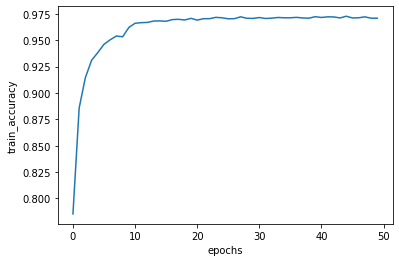

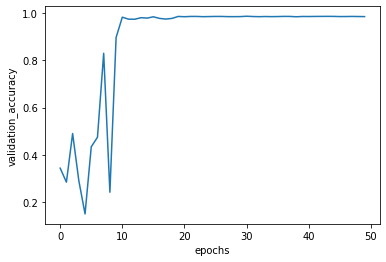

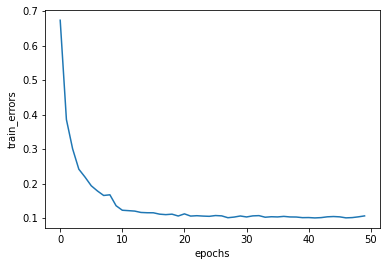

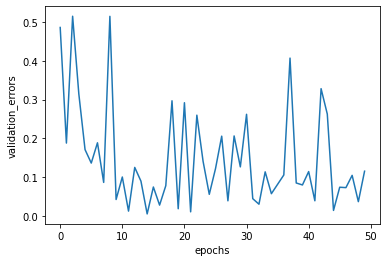

In [ ]:
plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

With dropout of 0.50 the train accuracy is good from the beggining . The validation accuracy imporves after 10 epochs as the learning rate reduces over time due to the learning rate scheduling and the model accuracy improves quicker when compared to the dropouts of 0.25 and 0.75

###Test Set


In [ ]:
 def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicted Labels

In [ ]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


###Test Accuracy and the Confusion Matrix on the test Set


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
accuracy=accuracy_score(y_true,y_pred)
confusion_matrix=confusion_matrix(y_true, y_pred)
print("Test Accuracy - ",accuracy*100,"%")
print(" \nConfusion Matrix- ")
print(confusion_matrix)

Test Accuracy -  98.71 %
 
Confusion Matrix- 
[[ 973    0    0    1    0    1    3    1    1    0]
 [   0 1127    1    2    0    3    1    1    0    0]
 [   2    3 1022    0    1    0    0    3    0    1]
 [   1    0    0 1000    0    2    0    6    1    0]
 [   0    0    1    0  972    0    4    0    1    4]
 [   2    0    0    2    0  884    2    1    1    0]
 [   6    1    0    0    4    3  944    0    0    0]
 [   0    4    8    1    0    1    0 1010    1    3]
 [   4    1    1    2    1    1    0    2  960    2]
 [   3    4    0    2    6    5    0    4    6  979]]


The baseline SGD model with batch normalisation has a test accuracy of 
98.71% which is slighlty lower than the baseline SGD model with dropout
0.25%.

##Define the CNN Model
####dropout-0.75

Dropout of 0.75 added to the CNN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.linear_block = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.75), #dropout of 0.75 added
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.75), #dropout of 0.75 added
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

Glorat Initialisation 

In [ ]:
def init_weights(m): 
  if type(m) == nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

In [ ]:
conv_model = Net()
conv_model.apply(init_weights) #Initialising the weights using the glorat Initialisation method
conv_model 

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.75, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.75, inplace=False)
    (8): Linear(i

###Defining the optimizer and loss functions

SGD Optimiser - 
params:- learning rate-0.05,momentum-0.9 
and using the Cross Entropy Loss Function

Learning Rate Schedular adjusting 10% every 10 epochs

torch.cuda to check if any gpu is available to use it. Google Collab GPU was used here to run the files.

In [ ]:
optimizer = torch.optim.SGD(params=conv_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.10) #learning rate scheduler
criterion = nn.CrossEntropyLoss() #cross entropy loss to calculate the loss between the predicted and the actual
if torch.cuda.is_available(): # To check if any gpu is available to run on
    print("GPU available")
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

GPU available


###Training the Model

In [ ]:
#Train the DNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    conv_model.train(True) 
    exp_lr_scheduler.step() #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            
            #Model computations
            out1 = conv_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      conv_model.eval()

      for local_batch,local_labels in val_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()

        #Model computations2
        out1=conv_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(val_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("Accuracy for ",epoch," epoch -","train_accuracy-",tr_accuracy," Validation_accuracy- ",dev_accuracy)



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Accuracy for  0  epoch - train_accuracy- 0.5477407407407408  Validation_accuracy-  0.1045
Accuracy for  1  epoch - train_accuracy- 0.6852962962962963  Validation_accuracy-  0.1045
Accuracy for  2  epoch - train_accuracy- 0.7227592592592592  Validation_accuracy-  0.0975
Accuracy for  3  epoch - train_accuracy- 0.7508518518518519  Validation_accuracy-  0.09866666666666667
Accuracy for  4  epoch - train_accuracy- 0.7694814814814814  Validation_accuracy-  0.0975
Accuracy for  5  epoch - train_accuracy- 0.7882592592592592  Validation_accuracy-  0.20566666666666666
Accuracy for  6  epoch - train_accuracy- 0.8017962962962963  Validation_accuracy-  0.11233333333333333
Accuracy for  7  epoch - train_accuracy- 0.8126666666666666  Validation_accuracy-  0.19083333333333333
Accuracy for  8  epoch - train_accuracy- 0.8266481481481481  Validation_accuracy-  0.09866666666666667
Accuracy for  9  epoch - train_accuracy- 0.8497222222222223  Validation_accuracy-  0.16683333333333333
Accuracy for  10  epoc

###Plotting the Learning Curves - for the Test and the Validation Sets

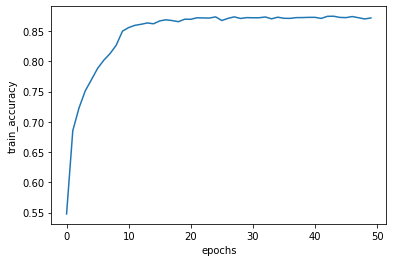

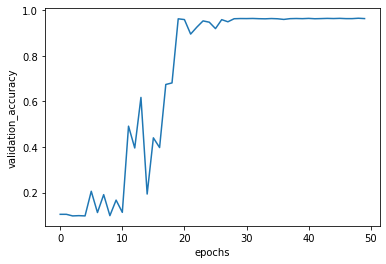

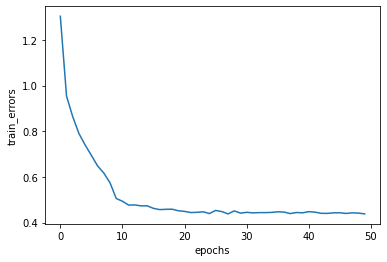

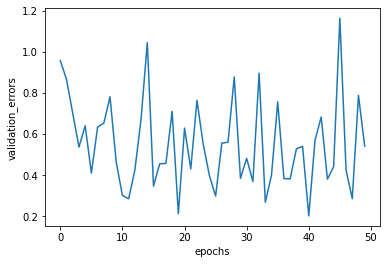

In [ ]:
plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

With dropout of 0.75 the train accuracy is low initially in the first few epochs after which it increases . The validation accuracy improves after 20 epochs as the learning rate reduces over time due to the learning rate scheduling.

###Test Set


In [ ]:
 def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicted Labels

In [ ]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


###Test Accuracy and the Confusion Matrix on the test Set


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
accuracy=accuracy_score(y_true,y_pred)
confusion_matrix=confusion_matrix(y_true, y_pred)
print("Test Accuracy - ",accuracy*100,"%")
print(" \nConfusion Matrix- ")
print(confusion_matrix)

Test Accuracy -  96.64 %
 
Confusion Matrix- 
[[ 964    0    2    0    0    2    5    1    5    1]
 [   0 1121    4    1    0    0    5    1    3    0]
 [   3    5  981   17    2    0    4   10    8    2]
 [   0    0    5  976    0    5    0    5   17    2]
 [   0    0    1    0  951    0   12    0    2   16]
 [   2    1    2   13    0  858    4    1    8    3]
 [   5    4    1    0    6   11  930    0    1    0]
 [   1    8   12   10    0    0    0  982    0   15]
 [   8    0    2    4    5    2    1    4  935   13]
 [   3    3    1    6   13    1    0    7    9  966]]


The baseline SGD model with dropout rate of 0.75 has a test accuracy of 
96.64 % which is lower than the baseline SGD model with dropout rates of 
0.25 and 0.50. 

###Inference
After running the model with the different dropout rates, from the observations based on this data I infer that with increase in the dropout rates the test accuracy tends to drop slightly. But it helps to regularize and thus may help with other data where the data is more spreadout.